SNN Test

In [4]:
!pip install snntorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.1 MB/s eta 0:00:00


In [5]:
# import numpy as np
# import itertools
# #import cv2
# #from google.colab import files
# import timeit
# from os import listdir
# import os
# from zipfile import ZipFile
# import gdown
# import shutil


# import snntorch as snn
# from snntorch import spikeplot as splt
# from snntorch import spikegen

# import torchvision.transforms.functional as TF
# from torch.utils.data import DataLoader, random_split
# from torchvision import datasets, transforms
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision
# from torchview import draw_graph
# from torchvision.transforms import ToTensor
# from torchshape import tensorshape

# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
# from sklearn.metrics import classification_report

#-----------------------------------------------
import sys
import snntorch as snn
from snntorch import spikeplot as split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools


print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
# print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
# print('Pandas version', pd.__version__)
print("env path: ", sys.executable) #[+]

#[+] check to see if gpu is available, else use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device: ',device)
for i in range(torch.cuda.device_count()): print('       -->',i,':', torch.cuda.get_device_name(i))

System Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Numpy version 2.0.2
env path:  /usr/bin/python3
Using device:  cpu


Downloading MNIST

In [6]:
batch_size= 128
data_path= r'./data'
dtype= torch.float

# Create the transoform for MNIST dataset to make sure its 28x28, grayscale, a tensor, and vals normalized to fall between 0 and 1
transform= transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),])

# Automatically downloads and splits the MNIST dataset
mnist_train = datasets.MNIST(data_path, train= True , download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train= False, download=True, transform=transform)

#create DataLoaders
train_loader= DataLoader(mnist_train , batch_size= batch_size, shuffle=True, drop_last=True)
test_loader= DataLoader(mnist_test , batch_size= batch_size, shuffle=True, drop_last=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.20MB/s]


Construct a Fully Connected SNN Architecture

In [7]:
# Number of inputs should match number of pixels in the MNIST img
num_inputs= 28*28  #= 784

# Hidden layer is however big you want as long as it fits in your GPU
num_hidden= 1000

# One output neuron for each of the 10 MNIST digits
num_outputs= 10

# 25 time steps is a quick simulation
num_steps= 25

# Rate of decay
beta= 0.95

#Modifying the code for storing the internal layer's spikes and membrane potential for DSA Analysis

In [8]:
# Define SNN Model
# ------------------------------
class Snn(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk1_rec = []
        mem1_rec = []
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return (
            torch.stack(spk2_rec), torch.stack(mem2_rec),
            torch.stack(spk1_rec), torch.stack(mem1_rec)
        )

# Initialize Model, Loss, Optimizer
# ------------------------------
model = Snn().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


In [9]:
# Training
# ------------------------------
num_epochs = 1
counter = 0

for epoch in range(num_epochs):
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)

        model.train()  # <- use new model name
        spk2_rec, mem2_rec, spk1_rec, mem1_rec = model(data.flatten(1))

        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val += loss_fn(spk2_rec.sum(0), targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        if counter % 10 == 0:
            print(f"Iteration: {counter} \t Train Loss: {loss_val.item()}")
        counter += 1

        if counter == 100:
            break


Iteration: 0 	 Train Loss: 2.498689889907837
Iteration: 10 	 Train Loss: 0.5817586183547974
Iteration: 20 	 Train Loss: 0.5833613276481628
Iteration: 30 	 Train Loss: 0.35333001613616943
Iteration: 40 	 Train Loss: 0.3682258129119873
Iteration: 50 	 Train Loss: 0.35971957445144653
Iteration: 60 	 Train Loss: 0.4438602924346924
Iteration: 70 	 Train Loss: 0.39386284351348877
Iteration: 80 	 Train Loss: 0.4067085087299347
Iteration: 90 	 Train Loss: 0.18974001705646515


In [10]:
import torch
import torch.nn as nn
import snntorch as snntorch  # rename here to avoid conflict

# Define your model as before
class Snn(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snntorch.Leaky(beta=beta)

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snntorch.Leaky(beta=beta)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk1_rec = []
        mem1_rec = []
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk1_rec.append(spk1)
            mem1_rec.append(mem1)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return (
            torch.stack(spk2_rec), torch.stack(mem2_rec),
            torch.stack(spk1_rec), torch.stack(mem1_rec)
        )

# Initialize model instance
model = Snn().to(device)

# Then evaluation:
print("\nExtracting hidden trajectories for DSA...")

hidden_mem_all = []
labels_all = []

model.eval()
with torch.no_grad():
    for i, (data, targets) in enumerate(test_loader):
        data = data.to(device)
        targets = targets.to(device)

        spk2_rec, mem2_rec, spk1_rec, mem1_rec = model(data.flatten(1))

        mem1_np = mem1_rec.permute(1, 0, 2).cpu().numpy()
        labels_np = targets.cpu().numpy()

        hidden_mem_all.append(mem1_np)
        labels_all.append(labels_np)

        if i == 5:
            break

hidden_mem_all = np.concatenate(hidden_mem_all, axis=0)
labels_all = np.concatenate(labels_all, axis=0)

print(f"Trajectory shape: {hidden_mem_all.shape} (samples, time, hidden)")
print(f"Labels shape: {labels_all.shape}")



Extracting hidden trajectories for DSA...
Trajectory shape: (768, 25, 1000) (samples, time, hidden)
Labels shape: (768,)


In [11]:
# ------------------------------
# Save for later DSA use
# ------------------------------
np.save("hidden_trajectories.npy", hidden_mem_all)
np.save("labels.npy", labels_all)


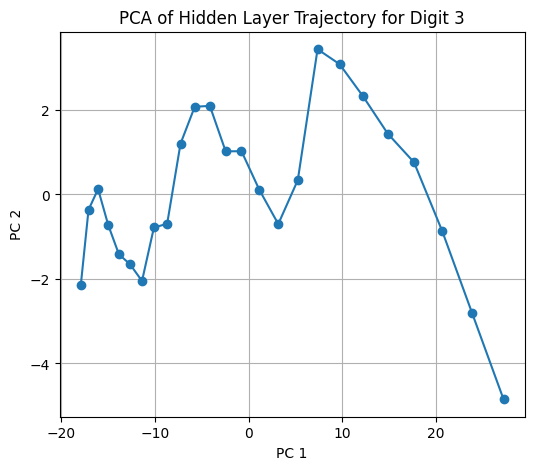

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# Plot sample trajectory using PCA
# ------------------------------
class_id = 3  # Choose the digit/class to plot
class_traj = hidden_mem_all[labels_all == class_id]  # Filter trajectories by class

if len(class_traj) > 0:
    sample_traj = class_traj[0]  # Take the first trajectory of the selected class [T, H]

    # Perform PCA to reduce hidden dimension to 2D for visualization
    pca = PCA(n_components=2)
    traj_2d = pca.fit_transform(sample_traj)

    plt.figure(figsize=(6, 5))
    plt.plot(traj_2d[:, 0], traj_2d[:, 1], marker='o')
    plt.title(f"PCA of Hidden Layer Trajectory for Digit {class_id}")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.show()
else:
    print(f"No trajectories found for class {class_id}")


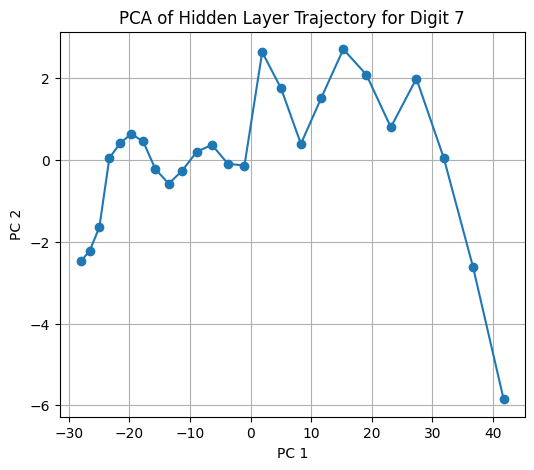

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# Plot sample trajectory using PCA
# ------------------------------
class_id = 7  # Choose the digit/class to plot
class_traj = hidden_mem_all[labels_all == class_id]  # Filter trajectories by class

if len(class_traj) > 0:
    sample_traj = class_traj[0]  # Take the first trajectory of the selected class [T, H]

    # Perform PCA to reduce hidden dimension to 2D for visualization
    pca = PCA(n_components=2)
    traj_2d = pca.fit_transform(sample_traj)

    plt.figure(figsize=(6, 5))
    plt.plot(traj_2d[:, 0], traj_2d[:, 1], marker='o')
    plt.title(f"PCA of Hidden Layer Trajectory for Digit {class_id}")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.show()
else:
    print(f"No trajectories found for class {class_id}")


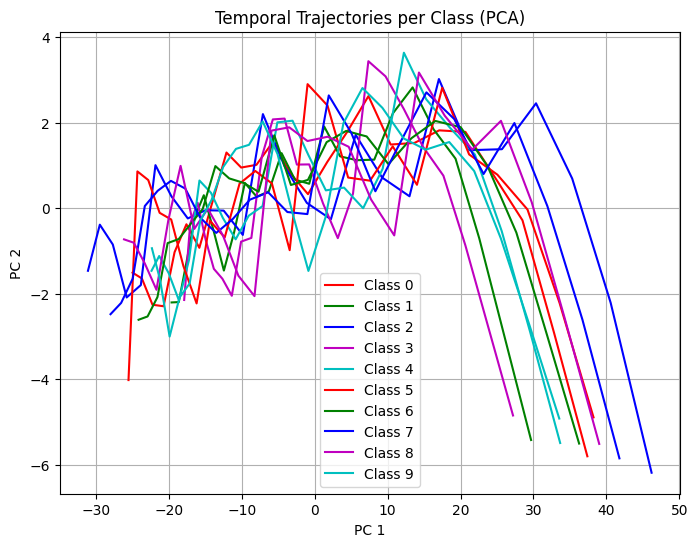

In [14]:
colors = ['r', 'g', 'b', 'm', 'c']
plt.figure(figsize=(8, 6))

for class_id in np.unique(labels_all):
    class_traj = hidden_mem_all[labels_all == class_id]
    if len(class_traj) == 0:
        continue
    sample_traj = class_traj[0]
    traj_2d = PCA(n_components=2).fit_transform(sample_traj)
    plt.plot(traj_2d[:, 0], traj_2d[:, 1], label=f"Class {class_id}", color=colors[class_id % len(colors)])

plt.title("Temporal Trajectories per Class (PCA)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()
